In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

#import joypy

import pyBigWig

/home/alla/anaconda3/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
def prepare_data_for_trips_frames1(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, name, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9, frames=[1,2,3], ylim=None):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    #f['Position'] = f['Position'] + 4
    
    #if f.iloc[0].Position == 1:
    f['Position'] = list(range(0, f.shape[0]))
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    d['frames'] = frames
    d['ylim'] = ylim
    
    return d

def trips_full_frames1(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    frames = d['frames']
    ylim = d['ylim']
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]
 
    ###########################
    ######## XLIMS ############
    ###########################
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    ###########################
    ######## YLIMS ############
    ###########################   
    if ylim is None:
        main_plot.set_ylim(0, max_height+max_height/l)
        main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
        main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    else:
        main_plot.set_ylim(0, ylim)
        main_plot.set_yticks(np.arange(0, ylim, p))
        main_plot.set_yticklabels(np.arange(0, ylim, p, dtype=np.int64), fontsize=font1)
        
    
    #############################
    ######## FRAMES #############
    #############################
    # #frame 1 = red, frame2 = green, frame3 = blue
    # frames are a bit disorganised here 
    if zeros == True:
        print ('changed frames!')
        if 1 in frames:
            main_plot.plot(f.Frame3.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(f.Frame1.tolist(), color = 'darkblue', linewidth=linewidth, linestyle='-')
    
    else:
        print ('changed frames!!!')
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        # 1=3
        # 2=2
        # 3=1
        
        # 1=3 
        # 2=1 
        # 3=2 
        if 1 in frames:
            main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'darkblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('darkblue')
    #cds.set_facecolor('lightgrey')
    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)
    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    #main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS or ORF
    #if orf is not None:
        #r#ect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    #p#rint ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            #if name == 'ENST00000381140_GTF3A':
                #N2 = 454 #stop codon of overlapping out-of-frame ORF 
                #rect = patches.Rectangle((415, 0), N2-415,1,linewidth=1,edgecolor='b',facecolor='silver')
                #orfs.add_patch(rect)
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                    
            #elif name == 'ENST00000265806_R3HCC1':
            #    Nst = 288
            #    N2 = 420
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)
                
            #elif name == 'ENST00000472232_BAG1':
            #    Nst = 254 
            #    N2 = 302
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)

            #else:
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                
                
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [3]:
path = '/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/'

# gencode 25
metadata_pc_g25 = pd.read_csv(path+'tmp_res/metadata_pc_g25.txt', sep='\t')
metadata_pc_g25['tr_id1'] = [x.split('.')[0] for x in metadata_pc_g25['tr_id'].tolist()] 

# open metadata with scores and metrics
meta = pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/tmp_res/METADATA_CURRENT.txt', sep='\t')


meta[0:2]

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,gene_ext,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,Nstart_Nend
0,ENST00000624431.1,274,316,42,274,316,14.0,FO538757.2,274,chr1:182667-182708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274-316
1,ENST00000624735.1,0,236,236,2,236,78.0,FO538757.1,86,chr1:200087-200236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-236


# VEGFB

2733
changed frames!!!
0


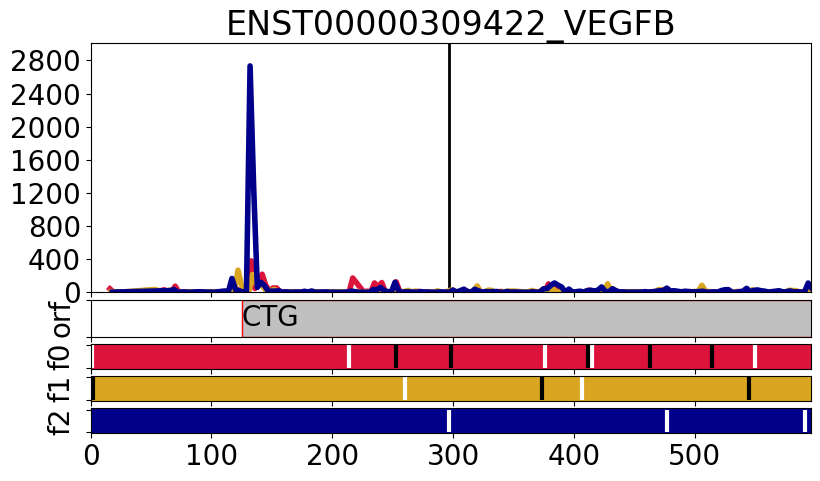

In [4]:
i = 6

tr_id = 'ENST00000309422'
gene = 'VEGFB'

pre_st = '125_CTG'

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+60*5]

d1 = prepare_data_for_trips_frames1(meta = metadata_pc_g25, 
                           file_counts = 'data/ELONG_frames/%s_%s.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p = 400, 
                             fraq = 100, 
                             cds = False,
                             name = 'test.png',
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            frames = [1,2,3],
                            zeros=False,
                            ylim = None)

trips_full_frames1(d1, name = 'test.png', font1=20, font2=24)

In [5]:
# data/TCPseq 

# NEW FUNCTION 

In [ ]:
def func_frames_corrections(filepath):
    df = pd.read_csv(filepath)

In [26]:
!ls data/ELONG_frames/VEGF*

data/ELONG_frames/VEGFB_ENST00000309422.csv
data/ELONG_frames/VEGFC_ENST00000618562.csv


In [ ]:
Position,Sequence,Frame 1,Frame 2,Frame 3,RNA-Seq
1,A,0,0,0,0
2,T,0,0,0,0
3,G,0,0,0,0
4,A,0,0,0,0
5,G,0,0,0,0
6,C,0,0,0,0
7,C,2,0,0,0
8,G,0,0,0,0
9,C,0,0,0,0
10,C,0,0,0,0
11,T,0,0,0,0
12,G,0,0,0,0
13,C,1,0,0,0
14,C,0,0,0,0
15,C,0,0,0,0

16,G,32,0,0,0

17,C,0,6,0,0
18,C,0,0,5,0
19,A,2,0,0,0

In [82]:
!mkdir -p data/ELONG_profiles/ELONG_profiles_corrected
!mkdir -p data/INIT_profiles/INIT_profiles_corrected

In [101]:
def correct_profiles(filepath, output_name = None):
    # 'data/ELONG_frames/VEGFB_ENST00000309422.csv'
    df = pd.read_csv(filepath)
    df.columns = ['Position', 'Sequence', 'Frame 1', 'Frame 2', 'Frame 3', 'rna_seq']
    df['Position'] = [x for x in range(1, df.shape[0]+1)]
    #df.columns = ['Position', 'Sequence', 'Frame 3', 'Frame 2', 'Frame 1', 'rna_seq'] 

    #df = df[['Position', 'Sequence', 'Frame 1', 'Frame 2', 'Frame 3', 'rna_seq']]

    df['Frame 1 adj'] = df['Frame 3'].tolist()[1:] + [0]
    df['Frame 2 adj'] = df['Frame 1'].tolist()[1:] + [0]
    df['Frame 3 adj'] = df['Frame 2'].tolist()[1:] + [0]

    df = df[['Position', 'Sequence', 
        'Frame 1 adj', 'Frame 2 adj', 
        'Frame 3 adj', 'rna_seq']]

    
    df.columns = ['Position', 'Sequence', 
        'Frame 1', 'Frame 2', 
        'Frame 3', 'rna_seq']
    
    if output_name is not None:
        df.to_csv('data/ELONG_profiles/ELONG_profiles_corrected/'+output_name, index=False)
    else:
        df.to_csv('data/ELONG_profiles/ELONG_profiles_corrected/'+filepath.split('/')[-1], index=False)
    
    
def correct_profiles_init(filepath):
    # 'data/ELONG_frames/VEGFB_ENST00000309422.csv'
    df = pd.read_csv(filepath)
    df['Position'] = [x for x in range(1, df.shape[0]+1)]
    #df.columns = ['Position', 'Sequence', 'Frame 3', 'Frame 2', 'Frame 1', 'rna_seq'] 

    #df = df[['Position', 'Sequence', 'Frame 1', 'Frame 2', 'Frame 3', 'rna_seq']]

    df['Frame 1 adj'] = df['Frame 3'].tolist()[1:] + [0]
    df['Frame 2 adj'] = df['Frame 1'].tolist()[1:] + [0]
    df['Frame 3 adj'] = df['Frame 2'].tolist()[1:] + [0]
    
    df = df[['Position', 'Sequence', 
        'Frame 1 adj', 'Frame 2 adj', 
        'Frame 3 adj', 'rna_seq']]
    
    df.columns = ['Position', 'Sequence', 
        'Frame 1', 'Frame 2', 
        'Frame 3', 'rna_seq']

    df.to_csv('data/INIT_profiles/INIT_profiles_corrected/'+filepath.split('/')[-1], index=False)

In [75]:
correct_profiles(filepath='data/ELONG_frames/VEGFB_ENST00000309422.csv')

In [76]:
!head -n 30 data/ELONG_profiles/ELONG_profiles_corrected/VEGFB_ENST00000309422.csv

Position,Sequence,Frame 1,Frame 2,Frame 3,rna_seq
1,A,0,0,0,
2,T,0,0,0,
3,G,0,0,0,
4,A,0,0,0,
5,G,0,0,0,
6,C,0,0,0,
7,C,0,0,0,
8,G,0,0,0,
9,C,0,0,0,
10,C,0,0,0,
11,T,0,0,0,
12,G,0,0,0,
13,C,0,0,0,
14,C,0,0,0,
15,C,0,0,0,
16,G,42,0,0,
17,C,0,7,0,
18,C,0,0,2,
19,A,3,0,0,
20,G,0,0,0,
21,C,0,0,0,
22,C,0,0,0,
23,C,0,1,0,
24,G,0,0,0,
25,G,4,0,0,
26,G,0,0,0,
27,C,0,0,0,
28,C,3,0,0,
29,C,0,0,0,


In [132]:
def prepare_data_for_trips_frames_no_CDS_TCPseq_INITseq(meta, file_counts, TCPseq_file, 
                                                        INITseq_file, metadata_pc_g25, 
                           tr_id, gene, l, p, l_tcp, p_tcp, fraq, cds, name,  
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9, frames=[1,2,3], ylim=None,ylim_tcp=None,
                                                frames_init = [1,2,3], zeros_init=True, 
                                                        p_init=10, ylim_init=100 
                                               ):
    
    # ELONG ribo-seq counts 
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    if f.iloc[0].Position == 1:
        f['Position'] = list(range(0, f.shape[0]))
        
    # TCP ribo-seq counts 
    tcp = pd.read_csv(TCPseq_file)
    tcp.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq', 'tcpseq']  
    if tcp.iloc[0].Position == 1:
        tcp['Position'] = list(range(0, tcp.shape[0]))
        
    # INIT ribo-seq counts
    init = pd.read_csv(INITseq_file)
    init.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    if init.iloc[0].Position == 1:
        init['Position'] = list(range(0, init.shape[0]))
        
    print ('INIT frame1 counts:', init['Frame1'].sum())
    print ('ELONG frame1 counts:', f['Frame1'].sum())
    print ('INIT frame2 counts:', init['Frame2'].sum())
    print ('ELONG frame2 counts:', f['Frame2'].sum())
    print ('INIT frame3 counts:', init['Frame3'].sum())
    print ('ELONG frame3 counts:', f['Frame3'].sum())
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    d['frames'] = frames
    d['ylim'] = ylim
    d['tcp'] = tcp['tcpseq'].tolist() #only read counts
    d['p_tcp'] = p_tcp
    d['ylim_tcp'] = ylim_tcp
    d['l_tcp'] = l_tcp
    d['init'] = init
    d['frames_init'] = frames_init
    d['zeros_init'] = zeros_init
    d['ylim_init'] = ylim_init
    d['p_init'] = p_init 
    
    # p_init, ylim_init 
    
    return d


def trips_full_frames(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    frames = d['frames']
    ylim = d['ylim']
    tcpseq_counts = d['tcp']
    l_tcp = d['l_tcp']
    p_tcp = d['p_tcp']
    ylim_tcp = d['ylim_tcp']
    init = d['init']
    zeros_init = d['zeros_init']
    frames_init = d['frames_init']
    ylim_init = d['ylim_init']
    p_init = d['p_init']
    
    fig, axes = plt.subplots(7, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10, 10,10,1.5,1,1,1]}, sharex=True, sharey=False)

    init_plot = axes[0]
    tcp_plot = axes[1]
    main_plot = axes[2]
    #cds = axes[1]
    orfs = axes[3]
    red = axes[4]
    green = axes[5]
    blue = axes[6]

    # x 
    tcp_plot.set_xlim(f.Position.min(), f.Position.max()+1)
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    if ylim is None:
        main_plot.set_ylim(0, max_height+max_height/l)
        main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
        main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    else:
        main_plot.set_ylim(0, ylim)
        main_plot.set_yticks(np.arange(0, ylim, p))
        main_plot.set_yticklabels(np.arange(0, ylim, p, dtype=np.int64), fontsize=font1)
        
    
    # print (f[125:150])
    
    
    #####################################################################
    ################## PLOT IniTseq counts ###############################
    #####################################################################
    
   # if zeros == True:
   #     print ('changed frames!')
   #     if 1 in frames:
   #         main_plot.plot(f.Frame3.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
   #     if 2 in frames:
   #         main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
   #     if 3 in frames:
   #         main_plot.plot(f.Frame1.tolist(), color = 'darkblue', linewidth=linewidth, linestyle='-')

    if zeros_init == True:
        if 3 in frames_init:
            t = init[['Position', 'Frame3']]
            init_plot.plot(t.Frame3.tolist(), color = 'crimson', 
                           linewidth=linewidth, linestyle='-', alpha=1)
        if 2 in frames_init:
            t = init[['Position', 'Frame2']]
            init_plot.plot(t.Frame2.tolist(), color = 'goldenrod', 
                           linewidth=linewidth, linestyle='-',
                          alpha=1)
        if 1 in frames_init:
            t = init[['Position', 'Frame1']]
            init_plot.plot(t.Frame1.tolist(), color = 'dodgerblue', 
                           linewidth=linewidth, linestyle='-', alpha=1)
    
    else:
        # delete zeros 
        t = init[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = init[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = init[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
       
        if 2 in frames:
            init_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), 
                           color = 'goldenrod', linewidth=linewidth, linestyle='-', alpha=1)
        if 3 in frames:
            init_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), 
                           color = 'dodgerblue', 
                           linewidth=linewidth, linestyle='-', alpha=1)
        if 1 in frames:
            init_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), 
                           color = 'crimson', linewidth=linewidth, linestyle='-', alpha=1)
    
    #if xlims is not False:
    #    max_height_tcp = np.max(tcpseq_counts[xlims[0]:xlims[1]])
    #    print ('TCP max height:', max_height_tcp)
    #else:
    #    max_height_tcp = np.max(tcpseq_counts)
    #    print ('TCP max height:', max_height_tcp)
    #
    #if ylim_tcp is None:
    #    tcp_plot.set_ylim(0, max_height_tcp+max_height_tcp/l_tcp)
    #    tcp_plot.set_yticks(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp))
    #    tcp_plot.set_yticklabels(['']+list(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp, dtype=np.int64))[1:], fontsize=font1)
    #else:
    
    # ylim_init, p_init
    init_plot.set_ylim(0, ylim_init)
    init_plot.set_yticks(np.arange(0, ylim_init, p_init))
    init_plot.set_yticklabels(['']+list(np.arange(0, ylim_init, p_init, dtype=np.int64))[1:], fontsize=font1)
        
    #####################################################################
    #####################################################################
    #####################################################################  
    
    #####################################################################
    ################## PLOT TCPseq counts ###############################
    #####################################################################

    
    tcp_plot.plot(tcpseq_counts, color = 'grey', linewidth=linewidth, linestyle='-')
    
    if xlims is not False:
        max_height_tcp = np.max(tcpseq_counts[xlims[0]:xlims[1]])
        print ('TCP max height:', max_height_tcp)
    else:
        max_height_tcp = np.max(tcpseq_counts)
        print ('TCP max height:', max_height_tcp)
    
    if ylim_tcp is None:
        tcp_plot.set_ylim(0, max_height_tcp+max_height_tcp/l_tcp)
        tcp_plot.set_yticks(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp))
        tcp_plot.set_yticklabels(['']+list(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp, dtype=np.int64))[1:], fontsize=font1)
    else:
        tcp_plot.set_ylim(0, ylim_tcp)
        tcp_plot.set_yticks(np.arange(0, ylim_tcp, p_tcp))
        tcp_plot.set_yticklabels(['']+list(np.arange(0, ylim_tcp, p_tcp, dtype=np.int64))[1:], fontsize=font1)
     
    ###################################################################
    ###################################################################

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        
        if 2 in frames:
            main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(f.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
        if 1 in frames:
            main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        if 1 in frames:
            main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('dodgerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    #main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS or ORF
    #if orf is not None:
        #r#ect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    #p#rint ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            #if name == 'ENST00000381140_GTF3A':
                #N2 = 454 #stop codon of overlapping out-of-frame ORF 
                #rect = patches.Rectangle((415, 0), N2-415,1,linewidth=1,edgecolor='b',facecolor='silver')
                #orfs.add_patch(rect)
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                    
            #elif name == 'ENST00000265806_R3HCC1':
            #    Nst = 288
            #    N2 = 420
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)
                
            #elif name == 'ENST00000472232_BAG1':
            #    Nst = 254 
            #    N2 = 302
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)

            #else:
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                
    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    init_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.12)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

# VEGFB

In [133]:
correct_profiles(filepath='data/ELONG_frames/VEGFB_ENST00000309422.csv')

In [134]:
correct_profiles_init(filepath='data/INIT_frames/VEGFB_ENST00000309422.csv')

In [135]:
!ls data/INIT_profiles/INIT_profiles_corrected

VEGFB_ENST00000309422.csv


In [136]:
!ls data/ELONG_profiles/ELONG_profiles_corrected

VEGFB_ENST00000309422_amb.csv  VEGFB_ENST00000309422.csv


INIT frame1 counts: 1356
ELONG frame1 counts: 3042
INIT frame2 counts: 1492
ELONG frame2 counts: 3016
INIT frame3 counts: 1342
ELONG frame3 counts: 8135
2733
TCP max height: 3511
0


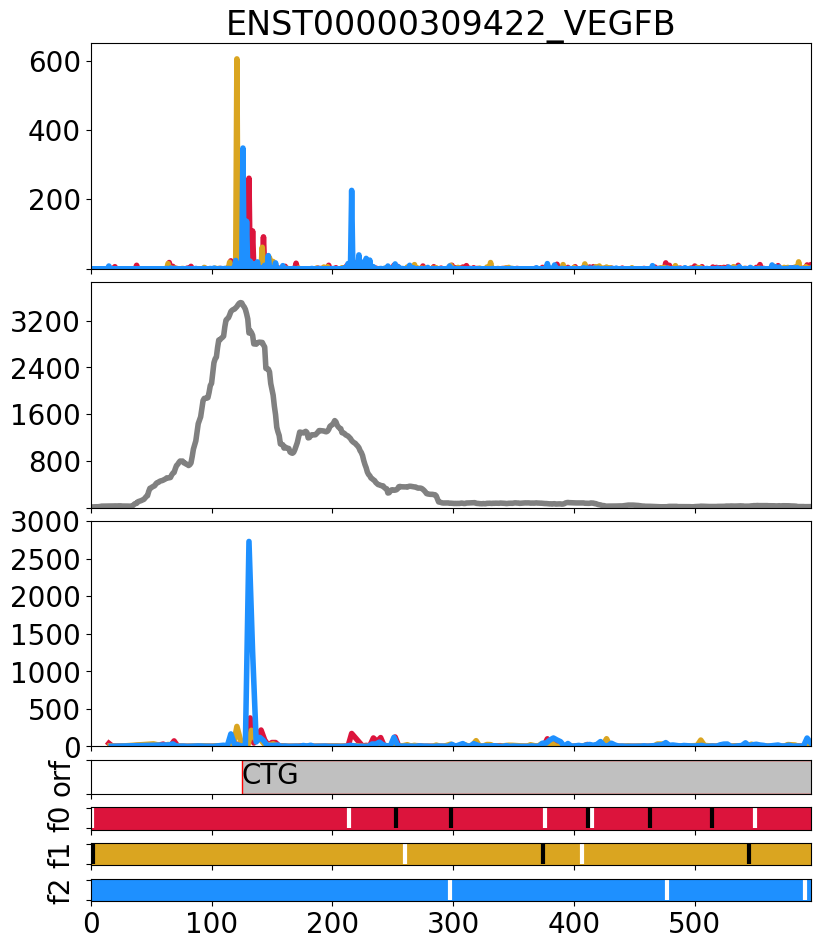

In [137]:
i = 6

tr_id = 'ENST00000309422'
gene = 'VEGFB'

pre_st = '125_CTG'

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+60*5]


d1 = prepare_data_for_trips_frames_no_CDS_TCPseq_INITseq(meta = metadata_pc_g25, 
                           file_counts = 'data/ELONG_profiles/ELONG_profiles_corrected/%s_%s.csv' % (gene, tr_id), 
                           TCPseq_file = 'data/TCPseq/%s.csv' % gene, 
                           INITseq_file = 'data/INIT_profiles/INIT_profiles_corrected/%s_%s.csv' % (gene, tr_id),
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500,
                             l_tcp=10, 
                             p_tcp=800,
                             fraq =100, 
                             cds = False,
                             name = 'VEGFB.png', 
                           figsize=(9, 11),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3],
                            frames_init = [1,2,3], zeros_init=True,
                             p_init=200, ylim_init=650
                           )


trips_full_frames(d1, name = 'test.png', font1=20, font2=24)

# VEGFB ambigous reads for elong data  

In [138]:
!head data/ELONG_frames/amb/VEGFB_ENST00000309422.csv

﻿Position,Sequence,Frame 1,Frame 2,Frame 3,RNA-Seq
1,A,0,0,0,0
2,T,0,0,0,0
3,G,0,0,0,0
4,A,0,0,0,0
5,G,0,0,0,0
6,C,0,0,0,0
7,C,2,0,0,0
8,G,0,0,0,0
9,C,0,0,0,0


In [139]:
#correct_profiles(filepath='data/ELONG_frames/amb/VEGFB_ENST00000309422.csv', output_name='VEGFB_ENST00000309422_amb.csv')

In [140]:
#!ls data/ELONG_profiles/ELONG_profiles_corrected/

INIT frame1 counts: 1356
ELONG frame1 counts: 3104
INIT frame2 counts: 1492
ELONG frame2 counts: 3162
INIT frame3 counts: 1342
ELONG frame3 counts: 8056
2720
TCP max height: 3511
0


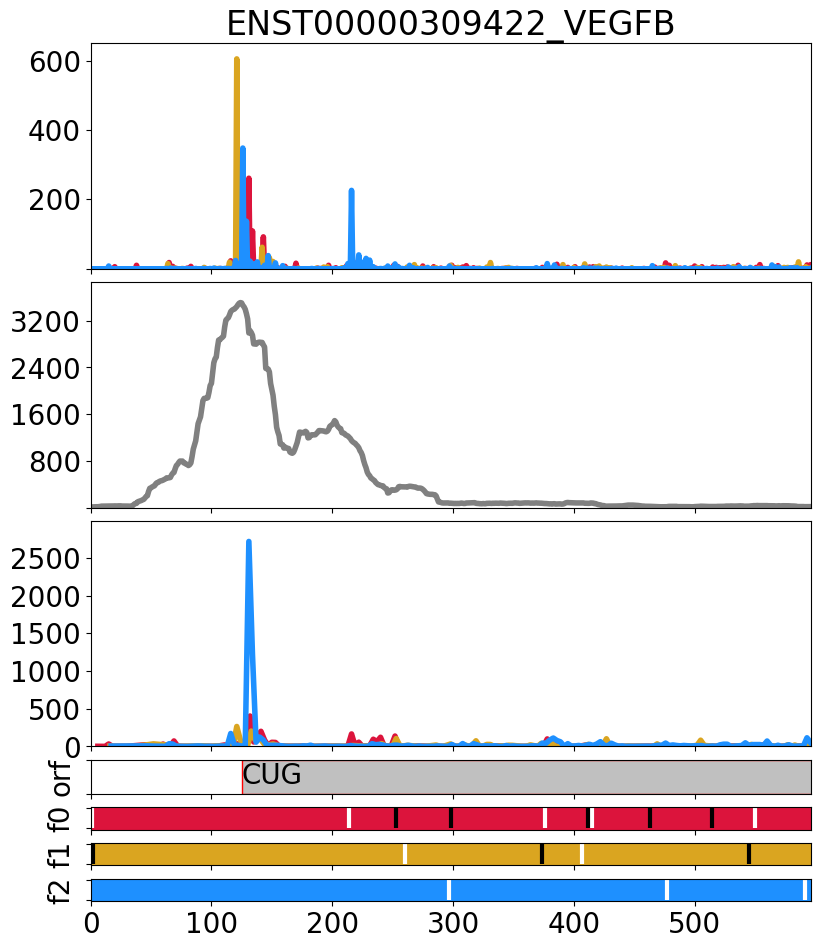

In [142]:
i = 6

tr_id = 'ENST00000309422'
gene = 'VEGFB'

pre_st = '125_CUG'

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+60*5]


d1 = prepare_data_for_trips_frames_no_CDS_TCPseq_INITseq(meta = metadata_pc_g25, 
                           file_counts = 'data/ELONG_frames/amb/%s_%s.csv' % (gene, tr_id), 
                           TCPseq_file = 'data/TCPseq/%s.csv' % gene, 
                           INITseq_file = 'data/INIT_profiles/INIT_profiles_corrected/%s_%s.csv' % (gene, tr_id),
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500,
                             l_tcp=10, 
                             p_tcp=800,
                             fraq =100, 
                             cds = False,
                             name = 'VEGFB.png', 
                           figsize=(9, 11),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3],
                            frames_init = [1,2,3], zeros_init=True,
                             p_init=200, ylim_init=650
                           )


trips_full_frames(d1, name = 'test.png', font1=20, font2=24)